In [1]:
from fastquant import get_stock_data
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
training_data = get_stock_data("AAPL", "2003-02-10", "2004-09-10")
testing_data = get_stock_data("AAPL", "2004-09-13", "2005-01-21")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
def data_prep(data):
    df = pd.DataFrame(data=None, columns=['fracChange','fracHigh','fracLow'])
    df['fracChange'] = (data['close']-data['open'])/data['open']
    df['fracHigh'] = (data['high']-data['open'])/data['open']
    df['fracLow'] = (data['open']-data['low'])/data['open']

    return df

In [4]:
x_train = data_prep(training_data)
x_test = data_prep(testing_data)

In [5]:
x_test.head()

,fracChange,fracHigh,fracLow
dt,,,
2004-09-13,-0.008082,0.005296,0.015608
2004-09-14,0.007094,0.008796,0.013054
2004-09-15,-0.004526,0.003392,0.015837
2004-09-16,0.032671,0.044320,0.003408
2004-09-17,0.016141,0.022708,0.004105


In [6]:
x_train.tail()

,fracChange,fracHigh,fracLow
dt,,,
2004-09-02,0.004507,0.008731,0.018874
2004-09-03,0.006283,0.025993,0.000000
2004-09-07,0.010169,0.022316,0.004803
2004-09-08,0.018207,0.024370,0.000560
2004-09-09,-0.011081,0.005539,0.022715


In [7]:
model = hmm.GMMHMM(n_components=4,n_mix=5,algorithm="map",n_iter=100)
model.fit(x_train)

GMMHMM(algorithm='map',
       covars_prior=array([[[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5,...
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]),
       means_weight=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]),
       n_components=4, n_iter=100, n_mix=

In [8]:
model.transmat_

array([[0.39708482, 0.30818584, 0.18946007, 0.10526927],
       [0.36099164, 0.37038837, 0.09851288, 0.1701071 ],
       [0.39748574, 0.44955824, 0.10041038, 0.05254564],
       [0.30128312, 0.36621069, 0.18908055, 0.14342564]])

In [11]:
closes = testing_data['close'].values
opens = testing_data['open'].values
preds = []

observed = x_train.iloc[-10:].values
for i in range(len(x_test)):
    # d = 10
    # create observed data of O_1,...,O_d,O_d+1
    # try 50x10x10 possible values for O_d+1 and find max log lik
    fracChange = np.arange(-0.1,0.1,0.2/50)
    fracHigh = np.arange(0,0.1,0.1/10)
    fracLow = np.arange(0,0.1,0.1/10)
    best = {'next_day': None, 'loglik': -math.inf}
    for change in fracChange:
        for high in fracHigh:
            for low in fracLow:
                next_day = np.array([change,high,low])
                observed_test = np.vstack((observed,next_day))
                log_lik = model.score(observed_test)
                if log_lik > best['loglik']:
                    best['next_day'],best['loglik'] = next_day,log_lik

    best_frac_change = best['next_day']
    observed = np.vstack((observed,next_day))
    # calc predicted close value
    pred_close = best['next_day'][0]*opens[i]+opens[i]
    preds.append(pred_close)

    # drop the O_1 observation to slide the window for the next observation
    observed = observed[1:]

    print(f'predicted close: {pred_close}')
    print(f'actual close   : {closes[i]}')

predicted close: 0.6381511337757111
actual close   : 0.6355360150337219
predicted close: 0.6267688472270966
actual close   : 0.6337500214576721
predicted close: 0.628903300523758
actual close   : 0.6285709738731384
predicted close: 0.626056689977646
actual close   : 0.6491069793701172
predicted close: 0.6500683100223542
actual close   : 0.6632140278816223
predicted close: 0.6559367208480835
actual close   : 0.6733930110931396
predicted close: 0.6714105870723724
actual close   : 0.6787499785423279
predicted close: 0.6776355514526368
actual close   : 0.6592860221862793
predicted close: 0.6587832720279694
actual close   : 0.6655359864234924
predicted close: 0.6660749881267548
actual close   : 0.665893018245697
predicted close: 0.6571816899776459
actual close   : 0.670179009437561
predicted close: 0.6662532649040223
actual close   : 0.679286003112793
predicted close: 0.6746117327213288
actual close   : 0.6907140016555786
predicted close: 0.693643298149109
actual close   : 0.691963970661163

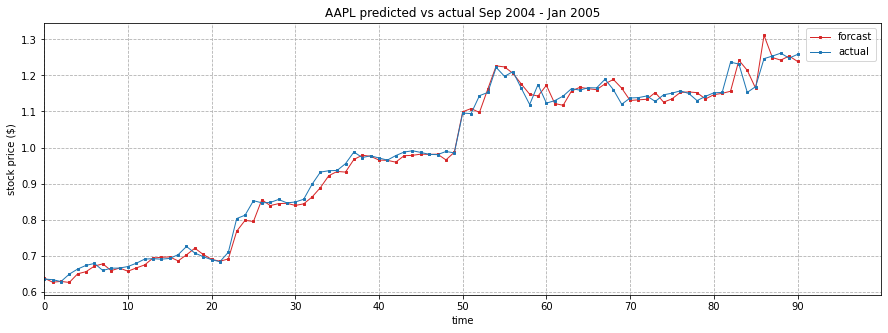

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('AAPL predicted vs actual Sep 2004 - Jan 2005')
time = range(len(preds))
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
ax.plot(time,closes,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,100,10))
ax.set_xlim(0,100)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()